# 4 point Thermometry Analysis ONLY

This script will be used purely to analyse the results of the 4 point ODMR measurements using only the temperature sensing algorithms as defined in the papers:
1. Singam et al (2019) - Nitrogen-vacancy nanodiamond based local thermometry using frequency-jump modulation
2. Fujiwaraet al (2020) - Real-time nanodiamond thermometry probing in vivo thermogenic responses. 

The aim of writing this script is to tidy up the original frankenstien script currently at the time of writing called: 
20210617_Analysis_Referenced_4_point_ODMR.ipynb

Unfortunately, I think I need to call in basically all the same functions and perform basically all the same analysis, but I will have fewer outputs and will structure everything a little bit nicer so that I can run everything from a single "main" cell at the bottom of the script and know that everything will get pulled in properly... I might have it so that any full CW ODMR script analysis is done in a separate cell just so I don't end up bogging down the whole script everytime it runs. 

In [1]:
import scipy.optimize as opt 
import numpy as np 
import matplotlib.pyplot as plot 
import os 
import pandas as pd
from scipy.signal import find_peaks

Pull in the data files and the associated params file. Also make the plots big enough to actually be able to see what's going on and read what's on the graphs. 

In [2]:
def load_data(file_path): 
    # load the ODMR data file in to an np array 
    data_array = np.loadtxt(file_path)
    return(data_array)

In [3]:
def load_params(file_path):
    # load in the params data. 
    params_data = pd.read_table(file_path, names = ['Parameter name', 'Parameter value']) 
    return(params_data)

In [4]:
def set_plot_params():
    # formats the plot parameters 
    plot.rcParams.update({'font.size' : 16})
    plot.rcParams.update({'figure.figsize' :[12, 8]})

Creates a numpy array with the microwave frequency scan range from the params file. 

In [5]:
def create_freq_scan(start, stop, step_size):
    # takes the scan parameters from the params data file. 
    step_size_GHz = step_size/1000
    number_of_steps = int((stop-start)/step_size_GHz)+1
    freq = np.linspace(start, stop, number_of_steps)
    return(freq)

Here we have the code to reshape the ODMR data into a 3D dataset according to the parameters that are given in the Params.txt file. 

Once the ODMR and reference Datasets have been restructured, then we can perform the normalisation of the ODMR dataset to the reference dataset.  

In [6]:
def reshape_data(reference_data, odmr_data, params_values):
    '''Here we re-shape the reference and the ODMR datasets into a 3D array, 
    based on the number of line scans, frequnecy points and repeats per frequnecy 
    have been used to build the ODMR dataset.'''
    
    # Create variables with the frequnecy scan parameters. 
    num_of_line_scans = int(params_values[4])
    num_of_freqs =  int(1000*(params_values[1]-params_values[0])/params_values[2] + 1)
    points_per_freq = int(params_values[8])
    print(num_of_line_scans, num_of_freqs, points_per_freq)
    # Reshape the ODMR and reference datasets. 
    odmr_shape_3D = odmr_data.reshape(num_of_line_scans, num_of_freqs, points_per_freq)
    reference_data_3D = reference_data.reshape(num_of_line_scans, num_of_freqs, points_per_freq)
    
    return(odmr_shape_3D, reference_data_3D)

In [7]:
def normalise_data(reference_data, odmr_data):
    '''Here we normalise the ODMR dataset to the reference data.'''

    norm_odmr_data = odmr_data/reference_data
    return(norm_odmr_data)

Find the mean of the ODMR dataset.

In [8]:
def mean_data(odmr_data):
    # find the mean data 
    mean_odmr_data_points =  np.mean(odmr_data, axis = 2)
    mean_odmr_data_points_and_linescans =  np.mean(mean_odmr_data_points, axis = 0)
    return(mean_odmr_data_points, mean_odmr_data_points_and_linescans)

Plot the Normalised ODMR data to a graph.

In [9]:
def normalised_scatter_plot(freq, mean_data):
    # Creates a scatter plot for experimental data and plot parameters. 
    fig2, ax2 = plot.subplots()
    ax2.scatter(freq, mean_data, marker = 'x',color = 'r', label = "ODMR Data")
    
    ax2.set_xlim(np.min(freq),np.max(freq))
    ax2.set_xlabel('Microwave Frequency (GHz)', fontsize = 18)
    ax2.set_ylabel('Normalised Counts (A.U.)', fontsize = 18)
    return(fig2, ax2)

Get the fitting parameters from the ODMR dataset and use these to fit a double Lorentzian lineshape to the normalised ODMR dataset.

In [10]:
def get_init_params(odmr_data, freq):
    # find the minima of the ODMR spectra and ODMR dip contrast and 
    # flourenscent baseline.
    
    half_data_length = int((len(freq)-1)/2) - 5 # This brings the mid-value to 2.87GHz 
    
    #find the indices for the lowest frequency value
    low_freq_min_index = np.where(odmr_data[0:half_data_length] == np.min(odmr_data[0:half_data_length]))
    high_freq_min_index = np.where(odmr_data[half_data_length:len(odmr_data)-1] == 
                                   np.min(odmr_data[half_data_length:len(odmr_data)-1]))
   
    # frequencies corresponding to ODMR minima
    freq_mins = [np.float(freq[low_freq_min_index[0]]),
                 np.float(freq[high_freq_min_index[0]+half_data_length])]
    
    # manually set frequencies. 
    
    #freq_mins = [2.78, 2.96]
    
    flourescent_baseline = np.mean(odmr_data)
    
    # approximate dip_depth
    dip_depth = [odmr_data[low_freq_min_index[0][0]]  - flourescent_baseline, 
                 odmr_data[high_freq_min_index[0][0]+half_data_length]  - flourescent_baseline]
    
    #contrast = [np.float((1-odmr_data[low_freq_min_index[0]]/flourescent_baseline)), 
    #            np.float((1-odmr_data[high_freq_min_index[0]+half_data_length]/flourescent_baseline))]

    return(freq_mins, dip_depth, flourescent_baseline)

In [11]:
def optimised_lorentz_fit(freq, mean_data, init_params, lower_bounds, upper_bounds):
    # A method to find the fitting prameters for the ODMR dataset. 
    y_error = np.sqrt(mean_data) # poissonian noise
    coeffs, confidence = opt.curve_fit(double_lorentz, freq, mean_data, init_params, 
                                       sigma = y_error, bounds = (lower_bounds, upper_bounds))
    opt_error = np.sqrt(np.diag(confidence))
    
    return(coeffs, opt_error)

In [12]:
def double_lorentz(x, A1, X01, sig1, A2, X02, sig2, offset): #P0[0], P0[1], P0[2], P0[3], P0[4], P0[5], P0[6]):
    # A1 = Amplitude 1, X01 = Resonance 1, sig1 = FWHM 1
    # A2 = Amplitude 2, X02 = Resonance 2, sig2 = FWHM 2, offset = offset
    
    first_peak = (A1/np.pi)*((sig1**2)/(sig1**2 +(2*x-2*X01)**2))
    second_peak = (A2/np.pi)*((sig2**2)/(sig2**2 +(2*x-2*X02)**2))
    
    return (first_peak + second_peak + offset)

In [13]:
def plot_fitting(ax2, freq, dwell_time):
    # plot the y fit. 
    
    high_res_freq = np.linspace(freq[0], freq[len(freq)-1], 10*len(freq)+1)
    
    # create the double lorentz fit array
    y_fit_high_res = double_lorentz(high_res_freq, fitting_params[0], fitting_params[1], fitting_params[2], 
                  fitting_params[3], fitting_params[4], fitting_params[5], fitting_params[6])
    
    y_fit = double_lorentz(freq, fitting_params[0], fitting_params[1], fitting_params[2], 
                  fitting_params[3], fitting_params[4], fitting_params[5], fitting_params[6])
    
    ax2.plot(high_res_freq, y_fit_high_res, color='k', label='Double Lorentz \nfitting')
    ax2.legend()
    
    return(ax2, y_fit)

*************************************************************************************************************************************************************************************

### Full CW ODMR Analysis

This should be a fairly base level referenced ODMR dataset analysis. From this, we should be able to reshape, normalise and plot the ODMR data.  
Additionally, I should be able to extract the Double Lorentz fitting of the dataset as it is needed for some of the further analysis.

*****************************************************************

1 261 100


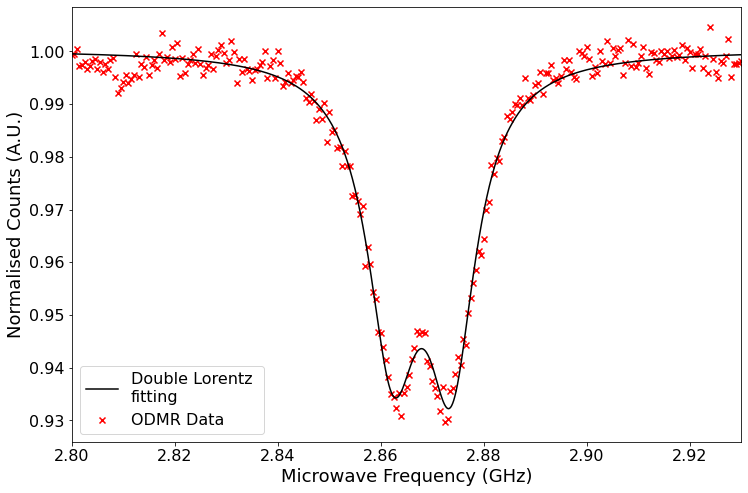

In [14]:
#######
 # This portion of the code produced the ODMR data plotting and the double lorentz fitting and 
 # Saves this data into a text file and the 2 plots generated. 
#######

date = '20210707' # Date on folder in which the experimental data is saved. 
set_plot_params()

# Load in the data file into an np array, and freqeuncy scan parameters 
# into a pandas array.
folder_path = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data\\ODMR\\ODMR and imaging\\' + date + '\\'
#folder_path = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data\\ODMR\\Imaging\\'

data_set = '_referenced_odmr_09' # Short hand for the file name. 

# Set the file names for all 4 data sets recorded from the experiment. 
file_name_ODMR1 = date + data_set + '_ODMR1.dat'
file_name_ODMR2 = date + data_set + '_ODMR2.dat'
file_name_Ref1 = date + data_set  + '_Ref1.dat'
file_name_Ref2 = date + data_set  + '_Ref2.dat'

# Extract the ODMR and reference datasets from the data we are looking at. 
odmr_data = load_data(folder_path + file_name_ODMR1)
reference_data = load_data(folder_path + file_name_Ref1)

# Get the parameters for the experiment. 
params_file = load_params(folder_path + date  + data_set + '_Params.txt')
params_values = params_file['Parameter value']

# Create the freqeuncy scan array. 
# Freq scan = frequency scan actually used in experiment, frreq = scan without triggering problems. 
freq = create_freq_scan(params_values[0], params_values[1], params_values[2])

# Dwell time of the measurment 
dwell_time = params_values[3]

# Reshape the ODMR and reference datasets. 
odmr_data, reference_data = reshape_data(reference_data, odmr_data, params_values)

# Normalise the ODMR data against the reference data. 
normalised_ODMR = normalise_data(reference_data, odmr_data)

# Mean of the normalise dataset. 
# mean_odmr_freq_points = mean for all the points recorded per frequnecy, but not linescans. 
# mean_norm_odmr_full = Mean fluorescence value for all ODMR data points taken per freq. 
mean_odmr_freq_points, mean_norm_odmr_full_disordered = mean_data(normalised_ODMR)
mean_norm_odmr_full = np.roll(mean_norm_odmr_full_disordered, 1)

# Plot the mean normalised dataset as a scatter plot. 
fig1, ax1 = normalised_scatter_plot(freq, mean_norm_odmr_full)

# find the freqeuncy points with the highest ODMR contrast
freq_mins, dip_depth, flourescent_baseline = get_init_params(mean_norm_odmr_full, freq)

# create the initial parameters for ODMR double lorentzian 
# line fitting
init_params = [dip_depth[0], freq_mins[0], 0.005, dip_depth[1], freq_mins[1], 0.005, flourescent_baseline]
#init_params = [-0.8, 2.86, 0.005, dip_depth[1], 2.87, 0.005, flourescent_baseline]

# Set the upper and lower bounds for the fitting algorithm. 
lower_bounds = [-np.inf, init_params[1] - 0.01, 0, -np.inf, init_params[4] - 0.01, 0, 0]
upper_bounds = [np.inf, init_params[1] + 0.01, 1, np.inf, init_params[4] + 0.01, 1, np.inf]

# generate the optimised curve fit parameters. 
fitting_params, error_in_fit = optimised_lorentz_fit(freq, mean_norm_odmr_full, init_params,
                                                    lower_bounds, upper_bounds)

# plot the fitting to ax1
ax1, y_fit = plot_fitting(ax1, freq, params_values[3])

***

### Begin the 4 point ODMR Analysis

Here I plan to:
1. Read in the 4 point ODMR data and the corresponding reference dataset.
2. Plot the normalised 4 point ODMR dataset against the fitted double Lorentz curve along with the intensitied of the 4 frequency points as expected from the fitted curve. 
3. Perform the analysis of the 4 point ODMR data using the method propsed by Fujiwara et al (2020).
4. perform the analysis of the 4 point ODMR dataset using the method proposed by Singam et al (2019). 

I will aim to make both the analysis methods such that it can take both a single mean value from the dataset and can analyse the full dataset to give a mean value for the T (or $\delta$D) and the standard deviation in the recorded values. This allows us to apply an error value to the recorded datapoints, which is probably a good thing.  

***

In [15]:
def fujiwara_analysis(four_freqs, mean_norm_4_point_odmr_full):
    '''Here we perform the analysis of the 4 point ODMR dataset using the method outlined in Fujiwara's paper from 2020'''
    
    # Find the frequency step (delta omega) used to split the 4 points away from the mid-point of the linear portion of the ODMR curve fitting. 
    freq_step = 0.5*((four_freqs[1]-four_freqs[0])*1000) # MHz conversion
    
    # The expected dD/dT from the paper published by Acosta et al 2013. 
    delta_D_delta_T = -0.075 # MHz/K
    
    # Calculate the numerator and denomiator for the equation used to determine the $\delta$ T for this experiment 
    numerator = (mean_norm_4_point_odmr_full[0] + mean_norm_4_point_odmr_full[1]) - (mean_norm_4_point_odmr_full[2] + mean_norm_4_point_odmr_full[3])
    denominator = (mean_norm_4_point_odmr_full[0] - mean_norm_4_point_odmr_full[1]) - (mean_norm_4_point_odmr_full[2] - mean_norm_4_point_odmr_full[3]) 

    # Calcuate dT and dD for this dataset. 
    deltaT1 = freq_step * (1/delta_D_delta_T) * numerator/denominator
    deltaD1 = deltaT1 * -0.075


    return(deltaD1, deltaT1)

In [16]:
def singam_freq_diff(four_freqs, f_step):
    '''Here we work to find the mean applied frequency for the 4 points applied to the negative and positive striaght line fittings. '''
    
    # Find the mean applied frequency of the 4 points.
    f_minus = (four_freqs[0]+four_freqs[1])/2
    f_plus = (four_freqs[2]+four_freqs[3])/2
    
    # Find the difference in frequency points applied. 
    delta_applied_f = f_plus - f_minus
    
    # Find the frequency difference in terms of indicies in the frequency array. 
    indice_shift = int(delta_applied_f/(f_step*0.001))
    
    return(f_minus, f_plus, indice_shift)
    

In [17]:
def singam_subtraction_array(y_fit, f_step, freq, index_shift):
    '''We create the arrays for the subtraction curve used as a reference to determine the shift in the frequency of the ODMR curve.'''
    
    subtraction_curve_length = len(freq) - index_shift
    
    # Create variables
    y_fit_subtract = []
    
    for i in range(subtraction_curve_length):
        y_fit_subtract.append(y_fit[i] - y_fit[i + index_shift])
    
    y_fit_subtract = np.array(y_fit_subtract)

    
    # create a frequnecy subtraction array for the above. 
    freq_sub_array = np.linspace(0, subtraction_curve_length-1, subtraction_curve_length)
    freq_sub_array = (freq_sub_array - int(subtraction_curve_length/2))*f_step
    
    return(y_fit_subtract, freq_sub_array)

In [18]:
def singam_extract_linear(f_step, y_fit_subtract):
    '''Here we extract the linear part of the subtracting curve as created in the above method.'''
    
    # How many frequnecy steps are needed to generate a +/- 3MHz region of the data
    pm_3_mhz = int(3/f_step)
    
    # find the max and min for the subtracted ODMR curve. 
    maxima = np.where(y_fit_subtract == np.max(y_fit_subtract))[0]
    minima = np.where(y_fit_subtract == np.min(y_fit_subtract))[0]
    
    # find the frequnecy equvilent to the point at which I(f1) and I(f4) are equal. 
    zero_intensity_freq = np.abs(y_fit_subtract[maxima[0]:minima[0]] - 0.00).argmin() + maxima[0]

    # the limits of the straight line portion of the subtracted ODMR curve. 
    min_index = zero_intensity_freq-pm_3_mhz
    max_index = zero_intensity_freq+pm_3_mhz
    
    return(zero_intensity_freq, max_index, min_index)

In [19]:
def straight_line(x, m, c):
    '''y = mx + c'''
    y = m*x + c
    return(y)

In [20]:
def singam_analysis(freq_high_res, mean_norm_4_point_odmr_full, two_freq_locs, linear_fit):
    '''Here we perform the analysis of the 4 point ODMR dataset using the method outlined in Singam's paper from 2019'''
    
    # Difference in intensity from the mean of (I(f1) + I(f2)) and (I(f3) + I(f4)) from the 4 point ODMR measurement 
    I_diff_mean = (mean_norm_4_point_odmr_full[3] + mean_norm_4_point_odmr_full[2])/2 - (mean_norm_4_point_odmr_full[0] + mean_norm_4_point_odmr_full[1])/2

    # The reference difference between the mean (I(f1+f2)) and (I(f3+f4)) from the lorentz fitting. 
    I_diff_mean_ref = y_fit[two_freq_locs[1]] - y_fit[two_freq_locs[0]] 

    # Find the index for frequnecy difference that corresponds to the differnec between (I(f1+f2)) and (I(f3+f4))
    I_diff_mean_freq_shift = (np.abs(linear_fit - I_diff_mean).argmin())

    # Find the reference frequnecy difference that corresponds to the differnec between (I(f1) + I(f2)) and (I(f3) + I(f4))
    I_diff_mean_freq_shift_ref = (np.abs(linear_fit - I_diff_mean_ref).argmin())
    
    # two_point_freq_shift - The change in resonant frequency calculated from the Singam method. 
    two_point_freq_shift = freq_high_res[I_diff_mean_freq_shift]
    
    #singam_reference_value - return the reference value used to determine the shift in frequency due to temp change. 
    singam_reference_value = freq_high_res[I_diff_mean_freq_shift_ref]
    
    return(I_diff_mean, I_diff_mean_ref, two_point_freq_shift, singam_reference_value)

*** 
### Here we analyse the 4 point referenced ODMR data
***

1 4 1000


Text(0, 0.5, 'Normalised Counts (A.U.)')

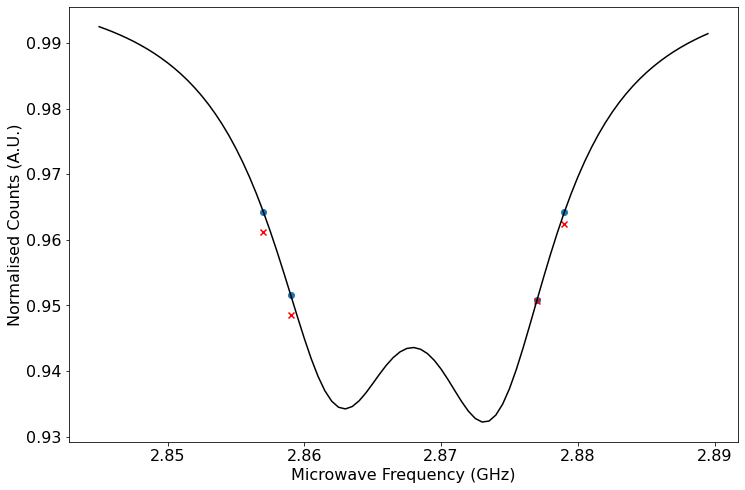

In [64]:
#######
 # This portion of the code produced the ODMR data plotting and the double lorentz fitting and 
#######

# Load in the data file into an np array, and freqeuncy scan parameters 
# into a pandas array.

four_point_data_set = '_4_point_referenced_odmr_39' # Short hand for the file name. 

# Set the file names for all 4 data sets recorded from the experiment. 
four_point_file_name_ODMR1 = date + four_point_data_set + '_ODMR1.dat'
four_point_file_name_ODMR2 = date + four_point_data_set + '_ODMR2.dat'
four_point_file_name_Ref1 = date + four_point_data_set  + '_Ref1.dat'
four_point_file_name_Ref2 = date + four_point_data_set  + '_Ref2.dat'

# Extract the ODMR and reference datasets from the data we are looking at. 
four_point_odmr_data = load_data(folder_path + four_point_file_name_ODMR1)
four_point_reference_data = load_data(folder_path + four_point_file_name_Ref1)

# Get the parameters for the experiment. 
four_point_params_file = load_params(folder_path + date  + four_point_data_set + '_Params.txt')
four_point_params_values = four_point_params_file['Parameter value']

# Reshape the data so that it can be used for the following script. 
four_point_odmr_data, four_point_reference_data = reshape_data(four_point_reference_data, four_point_odmr_data, four_point_params_values)

# Need to have the four_freqs array layered as follows [F1, F2, F3, F4] due to riggering problems in the software.  
four_freqs = [2.857 ,2.859, 2.877, 2.879]

# Normalise the ODMR data against the reference data. 
norm_odmr_4_point = normalise_data(four_point_reference_data, four_point_odmr_data)

# Mean of the normalise dataset. 
# mean_odmr_freq_points = mean for all the points recorded per frequnecy, but not linescans. 
# mean_norm_odmr_full = Mean fluorescence value for all ODMR data points taken per freq. 
mean_odmr_4_point_freq_points, mean_norm_4_point_odmr = mean_data(norm_odmr_4_point)
mean_norm_4_point_odmr = np.roll(mean_norm_4_point_odmr, 1)

plot.plot(freq[45*2:90*2], y_fit[45*2:90*2], color = 'k')

indices = []
indices.append(np.where((np.round(freq, 4) == four_freqs[0]))[0])
indices.append(np.where((np.round(freq, 4) == four_freqs[1]))[0])
indices.append(np.where((np.round(freq, 4) == four_freqs[2]))[0])
indices.append(np.where((np.round(freq, 4) == four_freqs[3]))[0])

indices = np.array(indices)

#plot.scatter(freq[50:85], y_fit[50:85])
plot.scatter(freq[indices], y_fit[indices], marker = 'o')

plot.scatter(four_freqs, mean_norm_4_point_odmr, color = 'r', marker = 'x')
plot.xlabel('Microwave Frequency (GHz)')
plot.ylabel('Normalised Counts (A.U.)')

***

### Fujiwara Analysis

***

In [65]:
# Run the Fuijiwara protocol. 
zumi_dD, zumi_dT = fujiwara_analysis(four_freqs, mean_norm_4_point_odmr)

try: 
    zumi_dD_store.append(zumi_dD)
    zumi_dT_store.append(zumi_dT)
except:
    zumi_dD_store = []
    zumi_dT_store = []
    zumi_dD_store.append(zumi_dD) # MHz
    zumi_dT_store.append(zumi_dT) # Kelvin

print(zumi_dD_store)
print(zumi_dT_store)

[0.19492606428152864, -0.138706525276547]
[-2.599014190420382, 1.8494203370206268]


In [88]:
## Used to clear the _store variables. 
#zumi_dD_store = []
#zumi_dT_store = []

# Perfrom the referencing to the start value. 
#for i in range(len(zumi_dD_store)-1):
#    print(zumi_dD_store[i+1]-zumi_dD_store[i])


***

### Singam Analysis
***

2.900900900900901 3.069069069069069
[0.16216216216216228, -0.16816816816816793]
[-2.162162162162164, 2.2422422422422392]


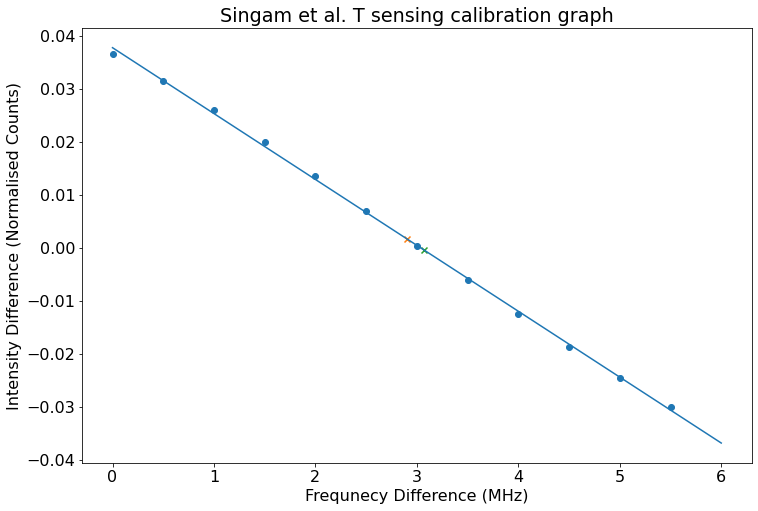

In [67]:
# Analysis of the 4 point ODMR is a little more challenging using the Singam protocol.

# Get the mean frequency values and the number of frequency steps between the two mean freq values. 
f_minus, f_plus, index_shift = singam_freq_diff(four_freqs, params_values[2])
# Create the subtraction plots (see plot for what this looks like).
y_fit_subtract, freq_sub_array = singam_subtraction_array(y_fit, params_values[2], freq, index_shift)

# Find the indicies corresponding to the maxima and minima of the y_fit subtracted lineshape.
# Also have the index corresponding to I(f1) - I(f2) = 0
zero_intensity_freq, max_index, min_index = singam_extract_linear(params_values[2], y_fit_subtract)

# Fit a straight line fit to the linear part of the subtraction curve. 
p0 = [0,0]
fit_coeffs, confidence = opt.curve_fit(straight_line, freq_sub_array[min_index:max_index], y_fit_subtract[min_index:max_index], p0)

# Generate a high resolution x and y straight line fit for the linear portion of the subtraction curve. 
freq_high_res = np.linspace(freq_sub_array[min_index], freq_sub_array[max_index], 1000)
linear_fit = straight_line(freq_high_res, fit_coeffs[0], fit_coeffs[1])

# Find the location of F_plus and F_minus in the normal frequency array. 
two_freq_locs = []
for i in range(2):
    a = ((four_freqs[i*2] + four_freqs[i*2 + 1])/2)
    two_freq_locs.append(np.abs(np.round(freq, 4) - a).argmin())

# Plot the high resolution straight line fit.
plot.plot(freq_high_res, linear_fit)
# Plot the points used to generate the original y_fit_subtraction curve. 
plot.scatter(freq_sub_array[min_index:max_index], y_fit_subtract[min_index:max_index])    
    
# Perform the Singam analysis for the mean of the 2 mean values from the 4 point ODMR data. 
I_diff_2_points, I_diff_mean_ref, two_point_freq_shift, singam_reference_value = singam_analysis(freq_high_res, 
                                                                                             mean_norm_4_point_odmr, 
                                                                                             two_freq_locs, linear_fit)    

# plot the reference value and the subtraction curve sampling points. 
plot.scatter(two_point_freq_shift, I_diff_2_points, marker = 'x')
plot.scatter(singam_reference_value, I_diff_mean_ref, marker = 'x')
plot.xlabel('Frequnecy Difference (MHz)')
plot.ylabel('Intensity Difference (Normalised Counts)')
plot.title('Singam et al. T sensing calibration graph')

# find the change in the resonant frequnecy of the NV centres from the reference.
delta_f_singam =  two_point_freq_shift - singam_reference_value # MHz

# Find the temperature change in the sample. 
delta_T_singam = delta_f_singam/(-0.075)

try: 
    delta_f_singam_store.append(delta_f_singam) # MHz
    delta_T_singam_store.append(delta_T_singam) # Kelvin
except:
    delta_f_singam_store = []
    delta_T_singam_store = []
    delta_f_singam_store.append(delta_f_singam)
    delta_T_singam_store.append(delta_T_singam)

print(two_point_freq_shift, singam_reference_value)

print(delta_f_singam_store)
print(delta_T_singam_store)

In [68]:
## Used to clear the delta_f_singam_store variable. 

#delta_f_singam_store = []
#delta_T_singam_store = []
print(delta_f_singam_store[1]-delta_f_singam_store[0])

# Perfrom the referencing to the start value. 
#for i in range(len(zumi_dD_store)-1):
#    print(delta_f_singam_store[i+1]-delta_f_singam_store[i])


-0.3303303303303302


***